# Qiskit Assignment 3
## Multiple Qubits, Entanglement, and Teleportation

### Learning Objectives
1. Understand the role of endianness in multi-qubit quantum circuits
2. Construct circuits with multiple qubits and entangled states
3. Solve a teleportation scenario

### Resources
Qiskit assignments are designed to be collaborative and open internet. Where possible, links to useful documentation will be embedded within questions. You're free to discuss these tasks with TAs and peers, but do write your own solutions. For some questions, there may be additional restrictions on the ways you can solve them. To ensure compliance with course policies and assignment instructions, we reserve the right to inspect your code.

**NAME**: REPLACE WITH YOUR NAME

**STUDENT ID**: REPLACE WITH YOUR STUDENT ID

In [1]:
# Import Qiskit and other needed packages
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
from qiskit_textbook.tools import array_to_latex
import matplotlib.pyplot as plt
import random
import numpy as np
import pprint

#### Task 1 - Endianness and Multi-Qubit Circuits (10 pts)

Qiskit uses a little endian convention for qubit ordering different from many textbooks and the lecture slides. Let's consider a circuit in the state $$\Psi=|0001\rangle$$

According to the convention used in lecture, the least significant qubit of the circuit, $q_0$, is in the state of the leftmost digit of $\Psi$, $|0\rangle$. In general, a state can be represented as $$|q_0,q_1,...,q_{n-1},q_n\rangle$$

Qiskit, however, interprets the rightmost digit, $|1\rangle$, as the state of the least significant qubit. This is the standard ordering of binary bitstrings, but it leads to a non-standard tensor product order ([source](https://qiskit.org/documentation/tutorials/circuits/1_getting_started_with_qiskit.html#OpenQASM-backend)). Hence, the general form of the Qiskit ordering goes $$|q_n,q_{n-1},...,q_1,q_0\rangle$$

We want to utilize the power of Qiskit for building and running quantum circuits while also remaining consistent with our notation and tensor product math. For this class, we'll stick to the big endian ordering. Qiskit provides two functions that can help.

We can use the [`reverse_bits`](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.reverse_bits.html#qiskit.circuit.QuantumCircuit.reverse_bits) method to return a quantum circuit with qubit ordering flipped completely. Recall that we used this method in the first qiskit assignment.
- Pros: good for running a job and displaying the counts and/or histogram in big endian notation
- Cons: returns a new vertically flipped circuit which may be disorienting

We can also use the Statevector class's [`reverse_qargs`](https://qiskit.org/documentation/stubs/qiskit.quantum_info.Statevector.reverse_qargs.html#qiskit-quantum-info-statevector-reverse-qargs) method to display the state of a multi-qubit circuit in big endian notation.
- Pros: preserves original form of the circuit
- Cons: not useful for displaying big endian counts in job results or a histogram

To check your understanding of qubit ordering in Qiskit, consider the following code which returns a circuit and its resulting statevector.
- modify the code such that `ket` is returned in big endian form without adding or modifying gates
- hints: 
 - what is the little endian state returned by the original code?
 - what is the corresponding big endian state?

In [2]:
def endianness():
    qc = QuantumCircuit(2,2)
    qc.h(0)
    qc.x(1)
    ket = Statevector.from_instruction(qc)
    # BEGIN SOLUTION
    ket = ket.reverse_qargs()
    # END SOLUTION
    return qc, ket

array_to_latex(endianness()[1], pretext="\\text{Task 1 SV} = ")

<IPython.core.display.Math object>

In [3]:
""" # BEGIN TEST CONFIG
hidden: false
points: 1
failure_message: EXPECTED CIRCUIT TO PRODUCE STATE [0, 1/sqrt(2), 0, 1/sqrt(2)]
""" # END TEST CONFIG
def test_statevector_1():
    return endianness()[1].equiv(Statevector([0,1/np.sqrt(2),0,1/np.sqrt(2)]))

test_statevector_1()

True

In [4]:
""" # BEGIN TEST CONFIG
hidden: false
points: 1
failure_message: EXPECTED CIRCUIT GATES TO REMAIN UNCHANGED FROM THE ORIGINAL CIRCUIT
""" # END TEST CONFIG
def test_gates_1():
    ops = len(endianness()[0].count_ops()) == 2
    h = endianness()[0].count_ops()['h'] == 1
    x = endianness()[0].count_ops()['x'] == 1
    i = 'initialize' not in endianness()[0].count_ops()
    return ops and h and x

test_gates_1()

True

In [5]:
""" # BEGIN TEST CONFIG
hidden: false
points: 8
failure_message: ONE OF THE ABOVE TESTS IS NOT PASSING
""" # END TEST CONFIG
def test_gates_1():
    ops = len(endianness()[0].count_ops()) == 2
    h = endianness()[0].count_ops()['h'] == 1
    x = endianness()[0].count_ops()['x'] == 1
    i = 'initialize' not in endianness()[0].count_ops()
    return ops and h and x

def test_statevector_1():
    return endianness()[1].equiv(Statevector([0,1/np.sqrt(2),0,1/np.sqrt(2)]))

test_statevector_1() and test_gates_1()

True

#### Task 2 (2A, 2B) - Multiple Qubit Circuits (30 pts)

#### Task 2A
- run the following cell
- return a circuit from `multi_qubit_a` that produces the following target state on measurement
- note:
 - it's fine if the resulting state is only equivalent up to a global phase
 - your qubits must start in $|00\rangle$ i.e. no initializations are allowed

In [6]:
array_to_latex([-1j/2, 1/2, -1/2, -1j/2], pretext="\\text{2A Target Statevector} = ")

<IPython.core.display.Math object>

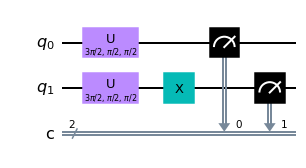

In [7]:
def multi_qubit_a():
    # BEGIN SOLUTION
    # hints for office hours: 
    # - 1: recognize the target state is tensor factorable so this is not an entangled state.
    # - 2: we can find what states the qubits need to be in individually.
    # - 3: If we prepare |0> on qubit zero and |1> on qubit one,
    # can use outer product from lecture 01 to obtain the matrix necessary to make this transformation
    # - 4: We can solve for the corresponding U gate parameters, see qiskit 1

    qc = QuantumCircuit(2,2)
    # primary solution - U gate
    phi = 3*np.pi/2
    theta = np.pi/2
    lamda = np.pi/2
    qc.u(phi,theta,lamda,0)
    qc.u(phi,theta,lamda,1)
    qc.x(1)
#     alternate solution - P, H, and X gates
#     qc_a.h(0)
#     qc_a.p(3*np.pi/2,0)
#     qc_a.h(1)
#     qc_a.p(3*np.pi/2,1)
#     qc_a.x(1)

    qc.measure(0,0)
    qc.measure(1,1)
    return qc.reverse_bits()
    # END SOLUTION

multi_qubit_a().reverse_bits().draw(output='mpl')

In [8]:
""" # BEGIN TEST CONFIG
hidden: false
points: 1
failure_message: EXPECTED 2 MEASUREMENTS TO BE MADE
""" # END TEST CONFIG
def testMeasurements_2a():
    ops = multi_qubit_a().count_ops()
    return 'measure' in ops and ops['measure'] == 2
    
testMeasurements_2a()

True

In [9]:
""" # BEGIN TEST CONFIG
hidden: false
points: 1
failure_message: EXPECTED CIRCUIT NOT TO USE INITIALIZE
""" # END TEST CONFIG
def testNoInitializations_2a():
    ops = multi_qubit_a().count_ops()
    return not 'initialize' in ops

testNoInitializations_2a()

True

In [10]:
""" # BEGIN TEST CONFIG
hidden: false
points: 1
failure_message: EXPECTED CIRCUIT TO RETURN THE TARGET STATEVECTOR, OR EQUIVALENT UP TO A GLOBAL PHASE
""" # END TEST CONFIG
def testAmplitudes_2a():
    qc = multi_qubit_a()
    qc.remove_final_measurements()
    ket = Statevector.from_instruction(qc)
    return Statevector([-1j/2, 1/2, -1/2, -1j/2]).equiv(ket)

testAmplitudes_2a()

True

In [11]:
""" # BEGIN TEST CONFIG
hidden: false
points: 12
failure_message: ONE OF THE ABOVE TESTS IS NOT PASSING
""" # END TEST CONFIG
def testMeasurements_2a():
    ops = multi_qubit_a().count_ops()
    return 'measure' in ops and ops['measure'] == 2

def testNoInitializations_2a():
    ops = multi_qubit_a().count_ops()
    return not 'initialize' in ops
    
def testAmplitudes_2a():
    qc = multi_qubit_a()
    qc.remove_final_measurements()
    ket = Statevector.from_instruction(qc)
    return Statevector([-1j/2, 1/2, -1/2, -1j/2]).equiv(ket)

testMeasurements_2a() \
and testAmplitudes_2a() \
and testNoInitializations_2a()

True

#### Task 2B
- run the following cell
- return a circuit from `multi_qubit_b` that produces the following target state on measurement
- note:
 - it's okay if your resulting state is equivalent up to a global phase
 - your qubits must start in state $|00\rangle$ i.e. no initializations are allowed.

In [12]:
array_to_latex([1/(2**(.5)), 0, 0, -1/(2**(.5))], pretext="\\text{2B Target Statevector} = ")

<IPython.core.display.Math object>

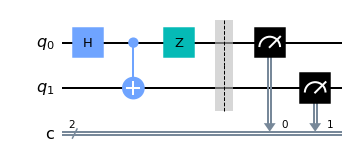

In [13]:
def multi_qubit_b():
    # BEGIN SOLUTION
    # hint: recognize the target state is a bell state; it's entangled and not tensor factorable
    # bell states are created in similar ways to each other, there is an example in lecture 10
    # on teleportation. the tensor of Z and I produces the desired negative
    qc = QuantumCircuit(2,2)
    qc.h(0)
    qc.cx(0,1)
    qc.z(0)
    qc.barrier()
    qc.measure(0,0)
    qc.measure(1,1)
    return qc.reverse_bits()
    # END SOLUTION

multi_qubit_b().reverse_bits().draw(output='mpl')

In [14]:
""" # BEGIN TEST CONFIG
hidden: false
points: 1
failure_message: EXPECTED CIRCUIT TO PERFORM 2 MEASUREMENTS
""" # END TEST CONFIG
def testMeasurements_2b():
    ops = multi_qubit_b().count_ops()
    return 'measure' in ops and ops['measure'] == 2

testMeasurements_2b()

True

In [17]:
""" # BEGIN TEST CONFIG
hidden: false
points: 1
failure_message: EXPECTED CIRCUIT TO NOT USE INITIALIZE
""" # END TEST CONFIG
def testNoInitializations_2b():
    ops = multi_qubit_b().count_ops()
    return not 'initialize' in ops

testNoInitializations_2b()

True

In [18]:
""" # BEGIN TEST CONFIG
hidden: false
points: 1
failure_message: EXPECTED CIRCUIT TO PRODUCE THE TARGET STATEVECTOR
""" # END TEST CONFIG
def testAmplitudes_2b():
    qc = multi_qubit_b()
    qc.remove_final_measurements()
    ket = Statevector.from_instruction(qc)
    return Statevector([1/(2**(.5)), 0, 0, -1/(2**(.5))]).equiv(ket)

testAmplitudes_2b()

True

In [19]:
""" # BEGIN TEST CONFIG
hidden: false
points: 12
failure_message: ONE OF THE ABOVE TESTS IS NOT PASSING
""" # END TEST CONFIG
def testMeasurements_2b():
    ops = multi_qubit_b().count_ops()
    return 'measure' in ops and ops['measure'] == 2

def testNoInitializations_2b():
    ops = multi_qubit_b().count_ops()
    return not 'initialize' in ops

def testAmplitudes_2b():
    qc = multi_qubit_b()
    qc.remove_final_measurements()
    ket = Statevector.from_instruction(qc)
    return Statevector([1/(2**(.5)), 0, 0, -1/(2**(.5))]).equiv(ket)

testMeasurements_2b() \
and testAmplitudes_2b() \
and testNoInitializations_2b()

True

#### Task 3 (3A, 3B) - What's in the box? (30 pts)

For Tasks 3A and 3B, devise quantum circuitry around the box (i.e. outside the barriers) such that a measurement tells you the contents of the box, without fail.

You are given a quantum box with a gate in it.  There is a promise that it is one gate or the other.   Devise circuitry around the box so that with one measurement you are certain which of the two gates is in the box.

#### Task 3A

The oracle promises to be **I** or **Z**.

**README**: 
- Your solutions to 3A and 3B may not use conditional (if) statements to dynamically pick gates according to the input or otherwise attempt to influence the oracle. In other words, the only gate in your circuit that may vary between runs is the oracle. 
- Do not use the parameter `r` in any code you write. 
- Do not use initialize. You only need to add familiar gates to complete these tasks

Solutions not adhering to these guidelines will not receive credit. As usual, we reserve the right to manually inspect your code.

In [20]:
def oracle_a(qc, r=None):
    if r is None:
        r = random.uniform(0, 1)
    qc.id(0) if r > 0.5 else qc.z(0)
    return qc

def whats_in_box_a(r=None):
    qc = QuantumCircuit(1,1) # SOLUTION
    
    # BEGIN SOLUTION
    # hint: use I:0, Z:1
    qc.h(0)
    # END SOLUTION
    
    qc.barrier()
    qc = oracle_a(qc,r)
    qc.barrier()
    
    # BEGIN SOLUTION
    qc.h(0)
    # END SOLUTION
    
    qc.measure(0,0)
    return qc

Use the following cells to verify your implementation is working as expected. Do **not** modify the cells below, though you may run them as much as you'd like.

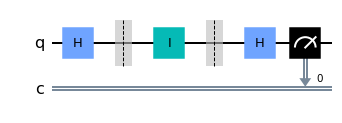

In [21]:
qc3a = whats_in_box_a()
qc3a.draw(output='mpl')

In [22]:
qc3a.remove_final_measurements()
array_to_latex(Statevector.from_instruction(qc3a).reverse_qargs(), pretext="\\text{3A last run} = ")

<IPython.core.display.Math object>

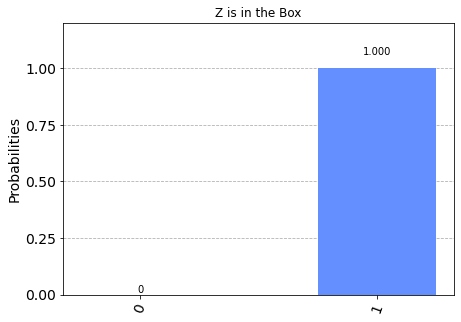

In [23]:
sim = BasicAer.get_backend("qasm_simulator")
job = execute(whats_in_box_a(.2), sim, shots=50)
counts = job.result().get_counts()
for state in ['0','1']:
    if state not in counts:
        counts[state] = 0
plot_histogram(counts, title="Z is in the Box")

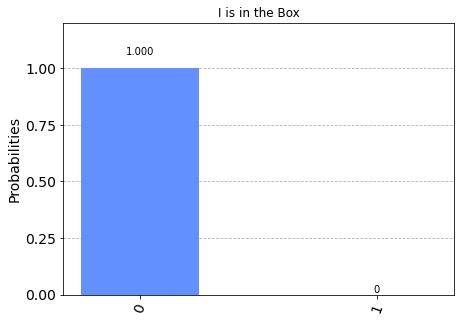

In [24]:
job = execute(whats_in_box_a(.7), sim, shots=50)
counts = job.result().get_counts()
for state in ['0','1']:
    if state not in counts:
        counts[state] = 0
plot_histogram(counts, title="I is in the Box")

#### Task 3B
The oracle promises to be **I**, **X**, **Y**, or **Z**.

Review the rules from 3A if it isn't clear what's allowed here.

In [25]:
def oracle_b(qc, r=None):
    if r is None:
        r = random.uniform(0, 1)
    if r < 0.25:
        qc.i(0)
        qc.i(1)
    elif r < 0.5:
        qc.x(0)
        qc.x(1)
    elif r < 0.75:
        qc.y(0)
        qc.y(1)
    else:
        qc.z(0)
        qc.z(1)
    return qc

def whats_in_box_b(r=None):
    qc = QuantumCircuit(2,2) # SOLUTION
    
    # BEGIN SOLUTION
    # hint: use I:00, X:01, Z:10, Y:11
    qc.h(0)
    # END SOLUTION
    
    qc.barrier()
    qc = oracle_b(qc,r)
    qc.barrier()
    
    # BEGIN SOLUTION
    qc.h(0)
    # END SOLUTION
    
    qc.measure(0,0)
    qc.measure(1,1)
    return qc

Use the following cells to verify your implementation is working as expected. Do **not** modify the cells below, though you may run them as much as you'd like.

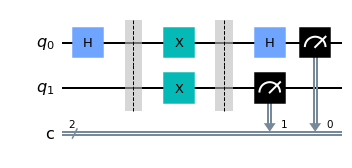

In [26]:
qc3b = whats_in_box_b()
qc3b.draw(output='mpl')

In [27]:
qc3b.remove_final_measurements()
array_to_latex(Statevector.from_instruction(qc3b).reverse_qargs(), pretext="\\text{3B last run} = ")

<IPython.core.display.Math object>

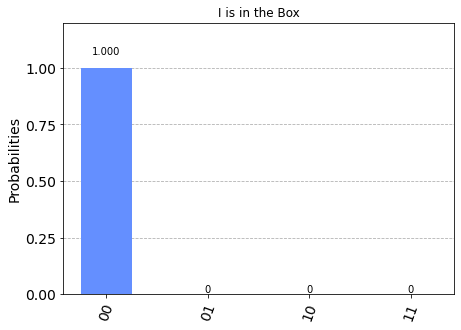

In [28]:
sim = BasicAer.get_backend("qasm_simulator")
job = execute(whats_in_box_b(.1).reverse_bits(), sim, shots=50)
counts = job.result().get_counts()
for state in ['00','01','10','11']:
    if state not in counts:
        counts[state] = 0
plot_histogram(counts, title="I is in the Box")

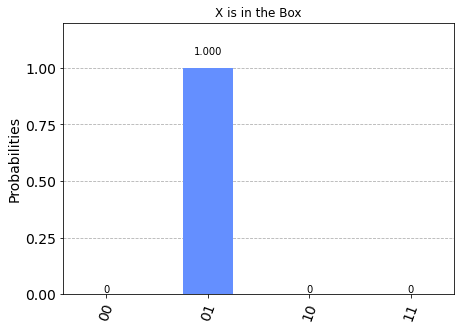

In [29]:
job = execute(whats_in_box_b(.3).reverse_bits(), sim, shots=50)
counts = job.result().get_counts()
for state in ['00','01','10','11']:
    if state not in counts:
        counts[state] = 0
plot_histogram(counts, title="X is in the Box")

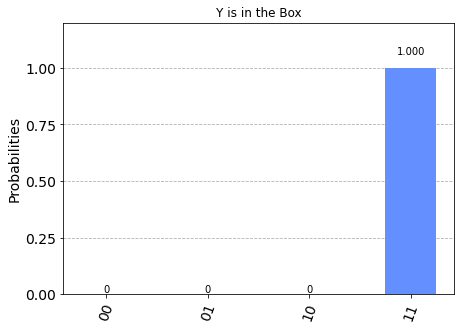

In [30]:
job = execute(whats_in_box_b(.6).reverse_bits(), sim, shots=50)
counts = job.result().get_counts()
for state in ['00','01','10','11']:
    if state not in counts:
        counts[state] = 0
plot_histogram(counts, title="Y is in the Box")

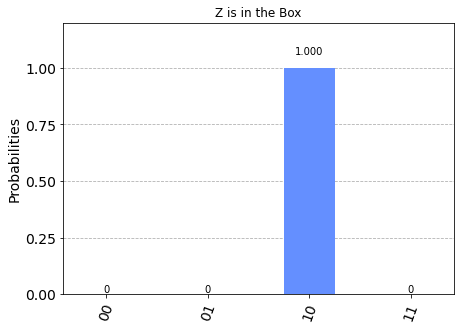

In [31]:
job = execute(whats_in_box_b(.9).reverse_bits(), sim, shots=50)
counts = job.result().get_counts()
for state in ['00','01','10','11']:
    if state not in counts:
        counts[state] = 0
plot_histogram(counts, title="Z is in the Box")

#### Task 4 (4A, 4B) - Teleportation (30 pts)
In lecture 10, we discussed how states may be sent between Alice and Bob even when they are separated by an arbitrary distance using the power of teleportation...spooky!

We'll revisit that experiment. This time, we'll start with a different bell state. Specifically, the EPR pair will be created as $$|\Psi^+\rangle = \frac{|01\rangle+|10\rangle}{\sqrt{2}}$$. 

#### Task 4A
Given partial circuitry for teleportation, your task is to play the role of Bob and apply the correct transformations to recover the states sent by Alice. Fill in `bobs_operations` below with the logic necessary to recover Alice's teleported state.

Hints: 
- Use [Qiskit's c_if gate](https://qiskit.org/documentation/stubs/qiskit.circuit.Gate.c_if.html#qiskit-circuit-gate-c-if)
- You may reference [Qiskit's implementation](https://qiskit.org/textbook/ch-algorithms/teleportation.html) of standard teleportation

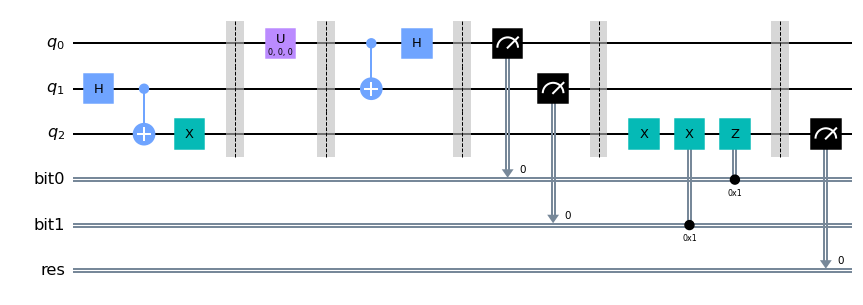

In [32]:
def teleport(u_gate_params=[0,0,0]):
    qr = QuantumRegister(3, name="q")
    bit0 = ClassicalRegister(1, name="bit0")
    bit1 = ClassicalRegister(1, name="bit1")
    res = ClassicalRegister(1, name="res")
    qc = QuantumCircuit(qr, bit0, bit1, res)
    # create EPR pair between Alice and Bob
    qc.h(1)
    qc.cx(1,2)
    qc.x(2)
    qc.barrier()
    # Alice prepares a state to teleport--assuming she doesn't know the parameters
    qc.u(*u_gate_params,0)
    qc.barrier()
    # Alice transforms for measurement
    qc.cx(0,1)
    qc.h(0)
    qc.barrier()
    # Alice performs measurements and sends values to Bob via classical channel
    qc.measure(0,0)
    qc.measure(1,1)
    qc.barrier()
    # Bob performs conditional operations based on classical bits
    qc = bobs_operations(qc)
    qc.barrier()
    # measure on Bob's transformed state
    qc.measure(2,2)
    return qc

def bobs_operations(qc):
    # here's the classical bits sent from Alice
    bit_0 = qc.cregs[0]
    bit_1 = qc.cregs[1]
    # you fill in the rest...
    
    # BEGIN SOLUTION
    # hint: use property that gates are their own inverses, so apply XX or ZZ when we don't want to use gate
    # hint: 00:X, 01:nothing, 10:XZ, 11:Z <-- bit0bit1:op0op1
    qc.x(2)
    qc.x(2).c_if(bit_1, 1)
    qc.z(2).c_if(bit_0, 1)
    # END SOLUTION
    
    return qc

teleport().draw(output='mpl')

In [33]:
""" # BEGIN TEST CONFIG
hidden: false
points: 1
failure_message: EXPECTED ALL AMPLITUDE TO BE ON STATE |0> FOR U-GATE PARAMETERS (0, 0, 0)
""" # END TEST CONFIG
def testKet0():
    sim = BasicAer.get_backend("qasm_simulator")
    qc = teleport()
    job = execute(qc, sim)
    counts = job.result().get_counts()
    zero = 0
    for k, v in counts.items():
        if int(k[0]) == 0:
            zero += v
    return zero == 1024

testKet0()

True

In [34]:
""" # BEGIN TEST CONFIG
hidden: false
points: 1
failure_message: EXPECTED ALL AMPLITUDE TO BE ON STATE |1> FOR U-GATE PARAMETERS (pi, 0, pi)
""" # END TEST CONFIG
def testKet1():
    sim = BasicAer.get_backend("qasm_simulator")
    qc = teleport(u_gate_params=[np.pi,0,np.pi])
    job = execute(qc, sim)
    counts = job.result().get_counts()
    one = 0
    for k, v in counts.items():
        if int(k[0]) == 1:
            one += v
    return one == 1024

testKet1()

True

In [35]:
""" # BEGIN TEST CONFIG
hidden: false
points: 1
failure_message: EXPECTED SOLUTION TO PASS A MORE COMPLEX STATE
""" # END TEST CONFIG
def testRandomParams():
    sim = BasicAer.get_backend("qasm_simulator")
    qc = teleport(u_gate_params=[131*np.pi/240,247*np.pi/332,347*np.pi/468])
    job = execute(qc, sim, shots=10000)
    counts = job.result().get_counts()
    zero = 0
    for k, v in counts.items():
        zero += v if int(k[0]) == 0 else 0
    return zero > 3850 and zero < 4600

testRandomParams()

True

In [36]:
""" # BEGIN TEST CONFIG
hidden: false
points: 7
failure_message: ONE OF THE ABOVE TESTS IS NOT PASSING
""" # END TEST CONFIG

def testKet0():
    sim = BasicAer.get_backend("qasm_simulator")
    qc = teleport()
    job = execute(qc, sim)
    counts = job.result().get_counts()
    zero = 0
    for k, v in counts.items():
        if int(k[0]) == 0:
            zero += v
    return zero == 1024

def testKet1():
    sim = BasicAer.get_backend("qasm_simulator")
    qc = teleport(u_gate_params=[np.pi,0,np.pi])
    job = execute(qc, sim)
    counts = job.result().get_counts()
    one = 0
    for k, v in counts.items():
        if int(k[0]) == 1:
            one += v
    return one == 1024

def testRandomParams():
    sim = BasicAer.get_backend("qasm_simulator")
    qc = teleport(u_gate_params=[131*np.pi/240,247*np.pi/332,347*np.pi/468])
    job = execute(qc, sim, shots=10000)
    counts = job.result().get_counts()
    zero = 0
    for k, v in counts.items():
        zero += v if int(k[0]) == 0 else 0
    return zero > 3850 and zero < 4600

testKet0() \
and testKet1() \
and testRandomParams()

True

#### Task 4B
So your circuit passes the tests, but what fun is that? 

Let's take things a step further.
- create a teleportation instance where Bob is `25%` likely to measure the teleported state as $|1\rangle$
 - i.e. pass a list of 3 U gate parameters to the `teleport` function
- store your measurements in `counts`; the provided code creates a histogram showing the target ratio using this variable

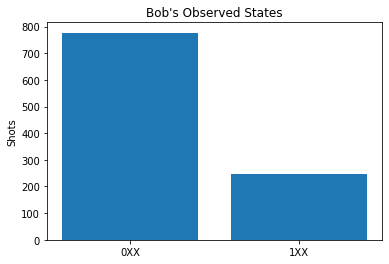

In [37]:
u_gate_params=[np.pi/3, 0, 0] # SOLUTION
# BEGIN SOLUTION
# students made this U gate in Qiskit 1
sim = BasicAer.get_backend("qasm_simulator")
qc = teleport(u_gate_params)
job = execute(qc, sim)
counts = job.result().get_counts()
# END SOLUTION

# do not change the code below
zero = 0
one = 0
for k, v in counts.items():
    if int(k[0]) == 0:
        zero += v
    else:
        one += v 

y = np.arange(2)
plt.bar(y, [zero, one])
plt.ylabel("Shots")
plt.xticks(y, ["0XX", "1XX"])
plt.title("Bob's Observed States")
plt.show()

Next up: the Deutsch–Jozsa algorithm!